In [1]:
import jax
import jax.numpy as jnp
import jaxkdtree

In [2]:
# Generating some random coordinates
pos = jax.random.normal(jax.random.PRNGKey(0), (12, 1000, 3))

## Batching

Check that batching works.

In [3]:
# Finding k=8 nearest neighbors, no batch
res_single_0 = jaxkdtree.kNN(pos[0], k=8, max_radius=100.0)
res_single_1 = jaxkdtree.kNN(pos[1], k=8, max_radius=100.0)

In [4]:
# Finding k=8 nearest neighbors, batched
res_batch = jax.vmap(jaxkdtree.kNN, in_axes=(0,None,None))(pos, 8, 100.0)

In [5]:
# Check that batched and unbatched give same result
jnp.allclose(res_batch[0], res_single_0), jnp.allclose(res_batch[1], res_single_1)

(Array(True, dtype=bool), Array(True, dtype=bool))

## JIT

Check that jit works.

In [6]:
# Make sure jit works
jax.jit(jax.vmap(jaxkdtree.kNN, in_axes=(0,None,None)), static_argnums=(1,2,))(pos, 8, 100.0);

## Compare to pairwise-distance calculation

Make sure we get the same answer with pairwise distances.

In [7]:
def pairwise_distances(point_cloud):
    """ Compute pairwise distances between points in a point cloud"""
    dr = point_cloud[:, None, :] - point_cloud[None, :, :]
    return jnp.sum(dr**2, axis=-1)

# Pairwise distances and sorted indices
distance_matrices = jax.vmap(pairwise_distances)(pos)
dist_results_indices = jnp.argsort(distance_matrices, axis=-1)[..., :8]

jnp.allclose(res_batch, dist_results_indices)

Array(True, dtype=bool)

## Different $k$

In [8]:
# Finding k=50 nearest neighbors, batched
res_batch = jax.vmap(jaxkdtree.kNN, in_axes=(0,None,None))(pos, 50, 100.0)

# Using pairwise-distance matrix
dist_results_indices = jnp.argsort(distance_matrices, axis=-1)[..., :50]

# Check that we get the same result
jnp.allclose(res_batch, dist_results_indices)

Array(True, dtype=bool)

## Benchmarking

In [58]:
import time

n_trials = 20
n_nodes_list = jnp.round(jnp.logspace(0, 5, 20))
n_batches = [1, 4, 8, 16]
t_stats = jnp.zeros((len(n_batches), n_trials, len(n_nodes_list)))

for i_batch, n_batch in enumerate(n_batches):
    for i_node, n_node in enumerate(n_nodes_list):
        
        pos = jax.random.normal(jax.random.PRNGKey(0), (n_batch, n_node.astype(jnp.int32), 3))
    
        for i_trial in range(n_trials):
            
            start = time.time()
            jax.vmap(jaxkdtree.kNN, in_axes=(0,None,None))(pos, 50, 100.0)
            end = time.time()
            
            t_stats = t_stats.at[i_batch, i_trial, i_node].set(end - start)

Text(0, 0.5, 'kNN construction time [s]')

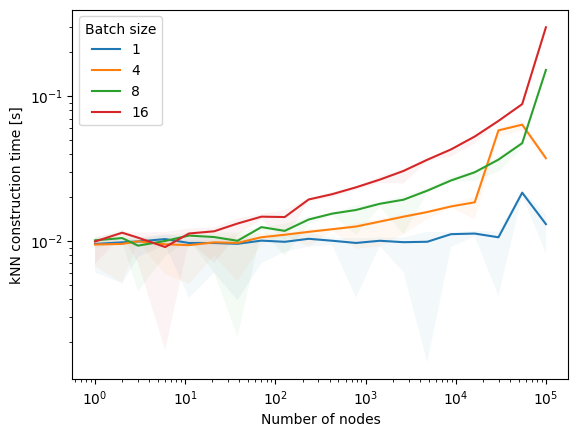

In [62]:
import matplotlib.pyplot as plt

for i_batch, n_batch in enumerate(n_batches):
    plt.plot(n_nodes_list, t_stats[i_batch].mean(0), label=n_batches[i_batch])
    plt.fill_between(n_nodes_list, jnp.percentile(t_stats[i_batch], 5, 0), jnp.percentile(t_stats[i_batch], 95, 0), alpha=0.05)
plt.legend(title="Batch size")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of nodes")
plt.ylabel("kNN construction time [s]")